# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Parse data from data frame
    """
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("/content/drive/My Drive/data_ML/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

In [ ]:
images.shape

(35887, 48, 48, 1)

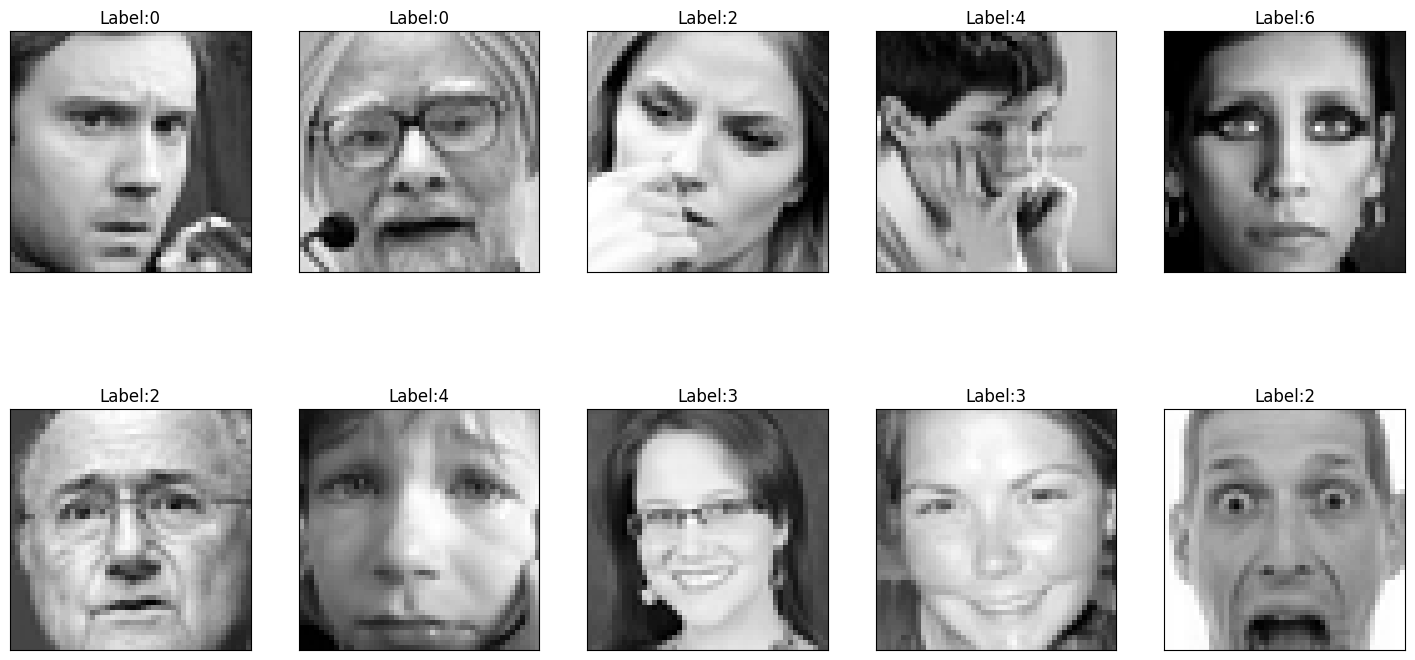

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

# Question 1

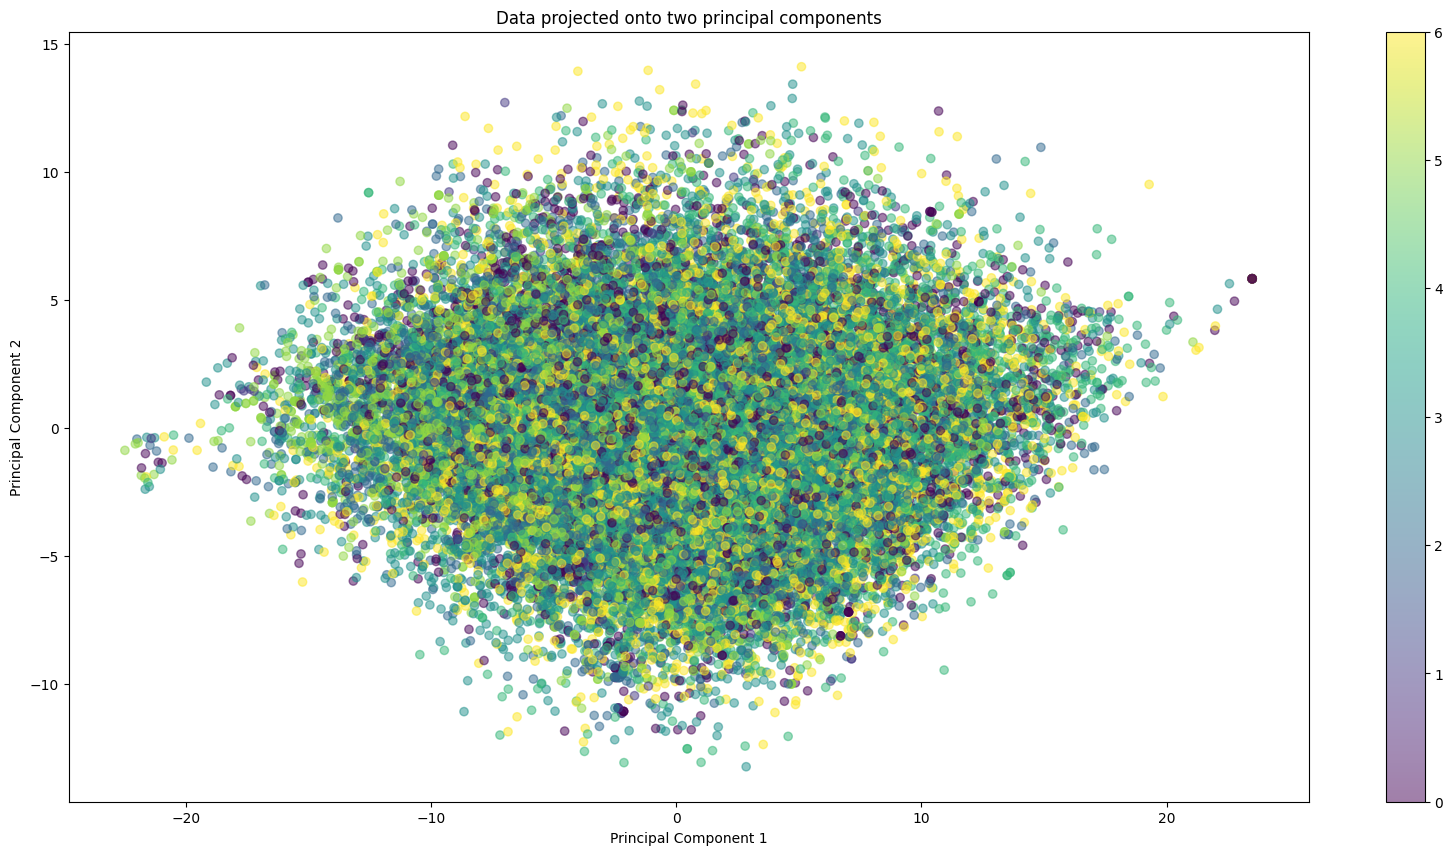

In [ ]:
# transform for visualizing here
# images_pca=pca.transform(images)
# modify images' array to the appropriate shape
# images_pca.shape

reshaped_images = images.reshape(images.shape[0], -1)

# Áp dụng PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(reshaped_images)

# Hiển thị dữ liệu đã được chiếu
plt.figure(figsize = (20, 10))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projected onto two principal components')
plt.show()

In [ ]:
print(images_pca.shape)

(35887, 2)


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)



---



# Question 2
Để xác định số lượng thành phần chính (principal components) tối ưu trong phân tích thành phần chính (PCA) bằng cách sử dụng `explained_variance_`, ta cần thực hiện các bước sau:

1. **Tính Tổng Phương Sai Giải Thích Được**:
   - Đầu tiên, tính tổng phương sai mà tất cả các thành phần chính giải thích được bằng cách cộng tất cả các giá trị trong `explained_variance_`. Đây là tổng sự biến thiên của dữ liệu mà PCA có thể nắm bắt.

2. **Tính Phần Trăm Phương Sai Giải Thích Được**:
   - Tiếp theo, tính phần trăm phương sai mà mỗi thành phần chính giải thích được bằng cách chia giá trị phương sai của từng thành phần cho tổng phương sai và nhân với 100. Điều này giúp ta biết được mỗi thành phần chính đóng góp bao nhiêu phần trăm vào tổng sự biến thiên của dữ liệu.

3. **Tính Phần Trăm Phương Sai Tích Lũy**:
   - Tính toán phần trăm phương sai tích lũy cho các thành phần chính, nghĩa là tổng cộng dồn các phần trăm phương sai từ thành phần chính đầu tiên đến thành phần hiện tại. Phần trăm phương sai tích lũy cho biết mức độ thông tin của dữ liệu gốc được giữ lại khi sử dụng các thành phần chính đó.

4. **Chọn Số Lượng Thành Phần Chính Tối Ưu**:
   - Xác định ngưỡng phần trăm phương sai mà ta muốn giữ lại. Sau đó, ta chọn số lượng thành phần chính sao cho tổng phần trăm phương sai tích lũy đạt hoặc vượt ngưỡng này. Số lượng thành phần chính tối ưu sẽ là số lượng ít nhất các thành phần chính mà tổng phần trăm phương sai tích lũy vượt ngưỡng mong muốn.

**Kết luận: Do đó, chúng ta sẽ chọn ngưỡng 95% để thực hiện cho bài toán này. Dựa trên khảo sát, với ngưỡng khoảng 99% sẽ cho ra số components ~ 880. Số chiều này còn khá cao sẽ khiến thời gian fit Model còn cao. Còn với 90% sẽ cho ra số components ~ 100, điều này sẽ khiến Model chạy tốt hơn. Tuy nhiên hiệu suất đem lại chưa thực sự tốt.**

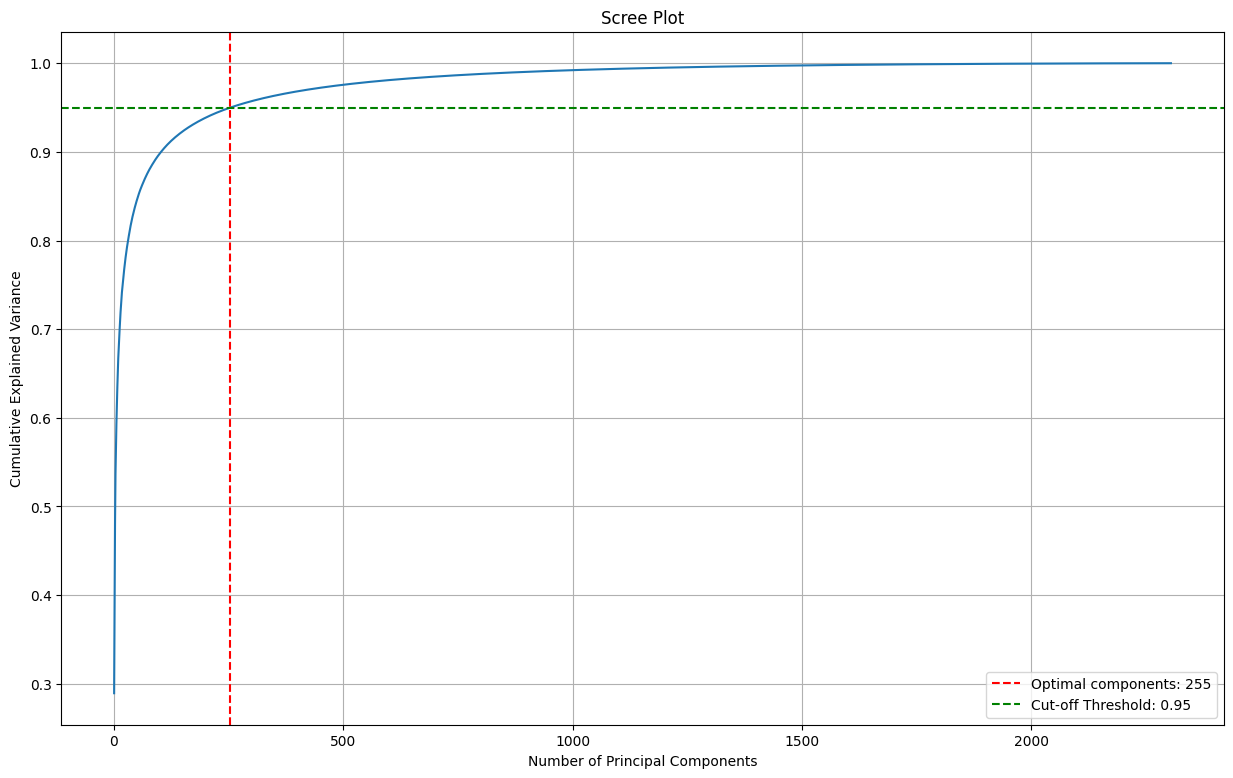

Optimal number of components: 255


In [ ]:
## determine the optimal number of PCs here
## pca.explained_variance_()

pca = PCA()
pca.fit(reshaped_images)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Threshold
threshold = 0.95

# Lấy explained_variance_
explained_variance = pca.explained_variance_

# Find Optimal components
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
# Elbow
plt.figure(figsize=(15, 9))
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axvline(n_components - 1, color='r', linestyle='--', label=f'Optimal components: {n_components}')
plt.axhline(y = 0.95, color='g', linestyle='--', label=f'Cut-off Threshold: {threshold}')
plt.legend()
plt.grid(True)
plt.show()


# Print Optimal components
print("Optimal number of components:", n_components)

# 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html



---



### SVM Model

#### Original Data

In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()

# Dữ liệu trước khi giảm chiều bằng PCA
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM trên dữ liệu đã giảm chiều bằng PCA
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Huấn luyện SVM và đánh giá hiệu suất trên dữ liệu đã chuẩn hóa nhưng không giảm chiều bằng PCA
svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Scaled Data:", accuracy)
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..............................................C=0.1; total time=31.9min
[CV] END ..............................................C=0.1; total time=32.1min
[CV] END ................................................C=1; total time=29.8min
[CV] END ...............................................C=10; total time=20.2min
[CV] END ................................................C=1; total time=29.9min
[CV] END ...............................................C=10; total time=20.7min
Accuracy on Scaled Data: 0.48286430760657567
              precision    recall  f1-score   support

           0       0.37      0.37      0.37       985
           1       0.89      0.49      0.63       102
           2       0.43      0.39      0.41      1043
           3       0.57      0.67      0.62      1765
           4       0.36      0.36      0.36      1210
           5       0.70      0.59      0.64       795
           6       0.45      0.

In [ ]:
# Xuất ra siêu tham số đã chọn
print("Best parameters found by GridSearchCV for PCA transformed data:", grid_search.best_params_)

Best parameters found by GridSearchCV for PCA transformed data: {'C': 10}


#### PCA Data

In [ ]:
# Huấn luyện và đánh giá mô hình SVM trên dữ liệu đã giảm chiều bằng PCA
svm_pca = SVC(random_state=42)
param_grid = {'C': [0.1, 1, 10]}
grid_search_svm_pca = GridSearchCV(estimator=svm_pca, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_svm_pca.fit(X_train_pca, y_train)

svm_best_pca = grid_search_svm_pca.best_estimator_
y_pred_svm_pca = svm_best_pca.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_svm_pca)
print("Accuracy on PCA Transformed Data:", accuracy_pca)
print(classification_report(y_test, y_pred_svm_pca))


Fitting 2 folds for each of 3 candidates, totalling 6 fits
Accuracy on PCA Transformed Data: 0.4891334633602675
              precision    recall  f1-score   support

           0       0.38      0.39      0.39       985
           1       0.82      0.52      0.63       102
           2       0.43      0.40      0.42      1043
           3       0.58      0.66      0.62      1765
           4       0.37      0.38      0.37      1210
           5       0.69      0.59      0.64       795
           6       0.46      0.44      0.45      1278

    accuracy                           0.49      7178
   macro avg       0.53      0.48      0.50      7178
weighted avg       0.49      0.49      0.49      7178



In [ ]:
# Xuất ra siêu tham số đã chọn
print("Best parameters found by GridSearchCV for PCA transformed data:", grid_search_svm_pca.best_params_)

Best parameters found by GridSearchCV for PCA transformed data: {'C': 10}




---



### Random Forest Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components = optimal_components)

X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth' : [10, 15],
    'min_samples_split': [10, 20]
}

In [ ]:
def evaluate_model(X_train, X_test, y_train, y_test, param_grid):
    grid = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=42), param_grid=param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best parameters: {grid.best_params_}")

    y_pred = grid.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    return y_pred, accuracy, precision, recall, f1

#### Original Data

In [ ]:
#Chạy mô hình với tập dữ liệu không PCA
print("Case: Scaled data (no PCA)")
y_pred_scaled, acc_scaled, prec_scaled, rec_scaled, f1_scaled = evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)

Case: Scaled data (no PCA)
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.45611590972415716
Precision: 0.45887106137563793
Recall: 0.45611590972415716
F1 Score: 0.4440914696722428

Classification report:
              precision    recall  f1-score   support

           0       0.48      0.24      0.32       985
           1       0.95      0.37      0.54       102
           2       0.44      0.29      0.35      1043
           3       0.49      0.67      0.57      1765
           4       0.35      0.39      0.37      1210
           5       0.55      0.62      0.58       795
           6       0.43      0.43      0.43      1278

    accuracy                           0.46      7178
   macro avg       0.53      0.43      0.45      7178
weighted avg       0.46      0.46      0.44      7178



#### PCA Data

In [ ]:
#Chạy mô hình với tập dữ liệu có PCA
print("Case: Scaled and PCA-transformed data")
y_pred_scaled_pca, acc_scaled_pca, prec_scaled_pca, rec_scaled_pca, f1_scaled_pca = evaluate_model(X_train_scaled_pca, X_test_scaled_pca, y_train, y_test, param_grid)

Case: Scaled and PCA-transformed data
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 300}
Accuracy: 0.4109779882975759
Precision: 0.4089932347534562
Recall: 0.4109779882975759
F1 Score: 0.3985059858586677

Classification report:
              precision    recall  f1-score   support

           0       0.39      0.20      0.26       985
           1       0.89      0.32      0.47       102
           2       0.39      0.27      0.32      1043
           3       0.46      0.62      0.53      1765
           4       0.32      0.37      0.34      1210
           5       0.50      0.58      0.54       795
           6       0.36      0.34      0.35      1278

    accuracy                           0.41      7178
   macro avg       0.47      0.39      0.40      7178
weighted avg       0.41      0.41      0.40      7178



In [ ]:
#Tạo bảng kết quả
data = [
    ['Scaled Data (no PCA)', acc_scaled, prec_scaled, rec_scaled, f1_scaled],
    ['Scaled and PCA-Transformed Data', acc_scaled_pca, prec_scaled_pca, rec_scaled_pca, f1_scaled_pca]
]

df_results = pd.DataFrame(data, columns=['Case', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

print(df_results)

                              Case  Accuracy  Precision    Recall  F1 Score
0             Scaled Data (no PCA)  0.456116   0.458871  0.456116  0.444091
1  Scaled and PCA-Transformed Data  0.410978   0.408993  0.410978  0.398506




---



### KNN Model

In [ ]:
X_flatten = images.reshape(images.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X_flatten, labels,shuffle = True, test_size=0.2, random_state=42)

pca = PCA(n_components= 2)
X_pca = pca.fit_transform(X_flatten)

#### Original Data

In [ ]:
pipe_ori = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search1 = GridSearchCV(estimator=pipe_ori, param_grid=param_grid_knn, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search1.fit(X_train, y_train)

y_pred_ori = grid_search1.best_estimator_.predict(X_test)

print("Best parameters found: ", grid_search1.best_params_)
print("Best cross-validation score: ", grid_search1.best_score_)
print("Test set classification report:\n", classification_report(y_test, y_pred_ori))
print("Test set score: ", grid_search1.best_estimator_.score(X_test, y_test))


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best parameters found:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best cross-validation score:  0.3606533303030255
Test set classification report:
               precision    recall  f1-score   support

           0       0.41      0.26      0.32       985
           1       0.44      0.48      0.46       102
           2       0.45      0.32      0.37      1043
           3       0.45      0.55      0.50      1765
           4       0.39      0.30      0.34      1210
           5       0.54      0.56      0.55       795
           6       0.33      0.46      0.38      1278

    accuracy                           0.42      7178
   macro avg       0.43      0.42      0.42      7178
weighted avg       0.42      0.42      0.41      7178

Test set score:  0.4186402897743104


#### PCA Data


In [ ]:
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=255)),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_pca= GridSearchCV(estimator=pipe_pca, param_grid=param_grid_knn, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search_pca.fit(X_train, y_train)

y_pred_pca = grid_search_pca.best_estimator_.predict(X_test)

print("Best parameters found: ", grid_search_pca.best_params_)
print("Best cross-validation score: ", grid_search_pca.best_score_)
print("Test set classification report:\n", classification_report(y_test, y_pred_pca))
print("Test set score: ", grid_search_pca.best_estimator_.score(X_test, y_test))

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best parameters found:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best cross-validation score:  0.35591614229576496
Test set classification report:
               precision    recall  f1-score   support

           0       0.43      0.25      0.31       985
           1       0.44      0.45      0.44       102
           2       0.42      0.32      0.36      1043
           3       0.44      0.55      0.49      1765
           4       0.37      0.31      0.34      1210
           5       0.59      0.55      0.57       795
           6       0.32      0.45      0.38      1278

    accuracy                           0.41      7178
   macro avg       0.43      0.41      0.41      7178
weighted avg       0.42      0.41      0.41      7178

Test set score:  0.41473948174979103




---



### MLP Model

In [ ]:
## splitting data into train/val/test subsets here
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(reshaped_images, labels,
                                                    shuffle = True, test_size = 0.2, random_state = 42)

#### Original Data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(max_iter = 1000, random_state = 42)

param_grid = {
    'hidden_layer_sizes': [(50, ), (100, ), (200, )],
    'alpha': [0.1, 0.01, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.01, 0.001, 0.0001],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

grid_search = GridSearchCV(estimator = mlp, param_grid = param_grid, cv = 2, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameter: ", grid_search.best_params_)
best_mlp_model = grid_search.best_estimator_

Fitting 2 folds for each of 216 candidates, totalling 432 fits
Best parameter:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'sgd'}


In [ ]:
mlp = MLPClassifier(max_iter = 1000, random_state = 42,
                    activation = 'relu', alpha = 0.1,
                    hidden_layer_sizes = (200, ), learning_rate = 'adaptive',
                    solver = 'sgd', learning_rate_init = 0.0001)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, y_pred_mlp))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.32      0.30      0.31       985
           1       0.64      0.27      0.38       102
           2       0.34      0.30      0.32      1043
           3       0.55      0.61      0.58      1765
           4       0.31      0.33      0.32      1210
           5       0.57      0.56      0.56       795
           6       0.40      0.40      0.40      1278

    accuracy                           0.43      7178
   macro avg       0.45      0.40      0.41      7178
weighted avg       0.42      0.43      0.42      7178



#### PCA Data

In [ ]:
from sklearn.model_selection import train_test_split

# Original data transform by PCA
reshaped_images = images.reshape(images.shape[0], -1)
pca = PCA(n_components = n_components)
pca.fit(reshaped_images)
images_pca = pca.transform(reshaped_images)

# Split dataset into train set and test set
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(images_pca, labels,
                                                                    shuffle = True, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

mlp = MLPClassifier(max_iter = 1000, random_state = 42)

param_grid = {
    'hidden_layer_sizes': [(200, )],
    'alpha': [0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

grid_search = GridSearchCV(estimator = mlp, param_grid = param_grid, cv = 2, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train_pca)

print("Best parameter: ", grid_search.best_params_)
best_mlp_model_pca = grid_search.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameter:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam'}


In [ ]:
mlp = MLPClassifier(max_iter = 1000, random_state = 42,
                    activation = 'relu', alpha = 0.01,
                    hidden_layer_sizes = (200, ), learning_rate = 'constant',
                    solver = 'adam', learning_rate_init = 0.001)
mlp.fit(X_train_pca, y_train_pca)
y_pred_pca_mlp = mlp.predict(X_test_pca)
print(classification_report(y_test_pca, y_pred_pca_mlp))

              precision    recall  f1-score   support

           0       0.29      0.28      0.29       985
           1       0.33      0.34      0.33       102
           2       0.30      0.31      0.30      1043
           3       0.52      0.52      0.52      1765
           4       0.32      0.33      0.32      1210
           5       0.52      0.53      0.52       795
           6       0.33      0.33      0.33      1278

    accuracy                           0.39      7178
   macro avg       0.37      0.38      0.38      7178
weighted avg       0.39      0.39      0.39      7178





---



# Question 3
## --- Với Original Data
### Mô Hình SVM
- **Accuracy**: 48%
- **Macro avg**:
  - Precision: 0.54
  - Recall: 0.47
  - F1 - Score: 0.50
- **Weighted avg**:
  - Precision: 0.49
  - Recall: 0.48
  - F1 - Score: 0.48
- **Hiệu suất theo từng lớp**:
  - Precision và Recall biến đổi nhiều qua các lớp.
  - Lớp 3 có Recall cao nhất là 0.67, cho thấy hiệu suất tốt trong việc nhận diện lớp này.

### Mô Hình RDF
- **Accuracy**: 46%
- **Macro avg**:
  - Precision: 0.53
  - Recall: 0.43
  - F1 - Score: 0.45
- **Weighted avg**:
  - Precision: 0.46
  - Recall: 0.46
  - F1 - Score: 0.44
- **Hiệu suất theo từng lớp**:
  - Lớp 1 có Precision rất cao (0.95) nhưng Recall ở mức trung bình (0.37).
  - Lớp 5 cho thấy sự cân bằng tốt giữa Precision (0.55) và Recall (0.62).

### Mô Hình KNN
- **Accuracy**: 42%
- **Macro avg**:
  - Precision: 0.43
  - Recall: 0.42
  - F1 - Score: 0.42
- **Weighted avg**:
  - Precision: 0.42
  - Recall: 0.42
  - F1 - Score: 0.41
- **Hiệu suất theo từng lớp**:
  - Hiệu suất khá kém ở tất cả các lớp.
  - Lớp 3 có Recall tốt hơn (0.55), cho thấy nó được nhận diện tốt hơn các lớp khác.

### Mô Hình MLP
- **Accuracy**: 43%
- **Macro avg**:
  - Precision: 0.45
  - Recall: 0.4
  - F1 - Score: 0.41
- **Weighted avg**:
  - Precision: 0.42
  - Recall: 0.43
  - F1 - Score: 0.42
- **Hiệu suất theo từng lớp**:
  - Lớp 5 có Recall cao nhất (0.56) và Precision (0.57).
  - Lớp 3 cho thấy sự cân bằng tốt với Recall 0.61 và Precision 0.55.

### So Sánh Tổng Quan
1. **accuracy**:
   - Mô hình SVM: 48%
   - Mô hình RDF: 46%
   - Mô hình KNN: 42%
   - Mô hình MLP: 43%

2. **Precision macro avg**:
   - Cao nhất: SVM (0.54)
   - Thấp nhất: KNN (0.43)

3. **Recall macro avg**:
   - Cao nhất: SVM (0.47)
   - Thấp nhất: KNN (0.42)

4. **F1 - Score macro abg**:
   - Cao nhất: SVM (0.50)
   - Thấp nhất: KNN (0.42)

5. **Hiệu suất theo từng lớp**:
   - Lớp 5: Thường được dự đoán tốt ở các mô hình.
   - Lớp 1: Precision cao ở RDF nhưng Recall thấp, cho thấy sự dự đoán không cân bằng.
   - Lớp 3: Recall tốt ở SVM và MLP.

### Nhận Định:
- **SVM** cho thấy Accuracy tốt nhất với Precision cao nhất và các số liệu trung bình cân bằng qua các lớp.
- **RDF** hoạt động khá ổn nhưng gặp khó khăn với accuracy so với SVM.
- **KNN** có số liệu tổng thể thấp nhất, cho thấy đây có thể không phải là lựa chọn tốt nhất cho bài toán phân loại này.
- **MLP** có hiệu suất trung bình với ưu thế ở các lớp cụ thể như Lớp 5.

### Kết Luận:
Mô hình SVM dường như có hiệu suất tốt nhất tổng thể với Precision cao nhất và các số liệu cân bằng qua các lớp, trong khi KNN cho thấy hiệu suất yếu nhất. RDF và MLP có hiệu suất trung bình, với điểm mạnh cụ thể ở một số lớp nhưng accuracy thấp hơn so với SVM.

## --- Với PCA Data

### Mô Hình SVM
- **Accuracy**: 0.49
- **Macro avg**:
  - Precision: 0.53
  - Recall: 0.48
  - F1-Score: 0.50
- **Weighted avg**:
  - Precision: 0.49
  - Recall: 0.49
  - F1-Score: 0.49
- **Hiệu suất theo từng lớp**:
  - Lớp 3 có recall cao nhất là 0.66 và F1 - Score cao nhất là 0.62, cho thấy mô hình nhận diện tốt lớp này.
  - Lớp 1 có precision cao nhưng recall thấp, cho thấy sự chênh lệch trong dự đoán.

### Mô Hình Random Forest
- **Accuracy**: 0.41
- **Macro avg**:
  - Precision: 0.47
  - Recall: 0.39
  - F1-Score: 0.40
- **Weighted avg**:
  - Precision: 0.41
  - Recall: 0.41
  - F1-Score: 0.40
- **Hiệu suất theo từng lớp**:
  - Lớp 1 có precision cao (0.89) nhưng recall chỉ đạt 0.32, cho thấy mô hình chưa cân bằng.
  - Lớp 3 và lớp 5 có sự cân bằng tốt hơn giữa precision và recall.

### Mô Hình KNN
- **Accuracy**: 0.41
- **Macro avg**:
  - Precision: 0.43
  - Recall: 0.41
  - F1-Score: 0.41
- **Weighted avg**:
  - Precision: 0.42
  - Recall: 0.42
  - F1-Score: 0.41
- **Hiệu suất theo từng lớp**:
  - Hiệu suất tổng thể kém ở tất cả các lớp, đặc biệt là lớp 0 với recall thấp (0.25).
  - Lớp 3 có recall cao nhất là 0.51, cho thấy khả năng nhận diện tương đối tốt.

### Mô Hình MLP
- **Accuracy**: 0.39
- **Macro avg**:
  - Precision: 0.37
  - Recall: 0.38
  - F1-Score: 0.38
- **Weighted avg**:
  - Precision: 0.39
  - Recall: 0.39
  - F1-Score: 0.39
- **Hiệu suất theo từng lớp**:
  - Hiệu suất tổng thể tương đối thấp ở tất cả các lớp.
  - Lớp 3 có sự cân bằng tốt nhất giữa precision (0.52) và recall (0.52).

### So Sánh Tổng Quan
1. **Accuracy**:
   - SVM: 0.49
   - Random Forest: 0.41
   - KNN: 0.41
   - MLP: 0.39

2. **Macro avg Precision**:
   - Cao nhất: SVM (0.53)
   - Thấp nhất: MLP (0.37)

3. **Macro avg Recall**:
   - Cao nhất: SVM (0.48)
   - Thấp nhất: Random Forest (0.39)

4. **Macro avg F1-Score**:
   - Cao nhất: SVM (0.50)
   - Thấp nhất: MLP (0.38)

5. **Hiệu suất theo từng lớp**:
   - Lớp 1: precision cao nhưng recall thấp ở Random Forest.
   - Lớp 3: Sự cân bằng tốt ở cả SVM và MLP.
   - Lớp 5: Được nhận diện tốt ở Random Forest và MLP.

### Nhận Định
- **SVM** có hiệu suất tốt nhất tổng thể với precision cao và các chỉ số trung bình cân bằng.
- **Random Forest** và **KNN** có hiệu suất tương đối tương đồng, nhưng không bằng SVM.
- **MLP** có hiệu suất thấp nhất, đặc biệt là về Accuracy và các chỉ số trung bình.

### Kết Luận
Mô hình SVM tiếp tục cho thấy hiệu suất tốt nhất với Accuracy cao nhất và các chỉ số trung bình cân bằng. Random Forest và KNN có hiệu suất khá nhưng không bằng SVM, trong khi MLP có hiệu suất thấp nhất. Điều này cho thấy SVM là lựa chọn phù hợp nhất cho bài toán phân loại này trên dữ liệu đã được PCA.




---



# 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



### Confusion Matrix of KNN Model

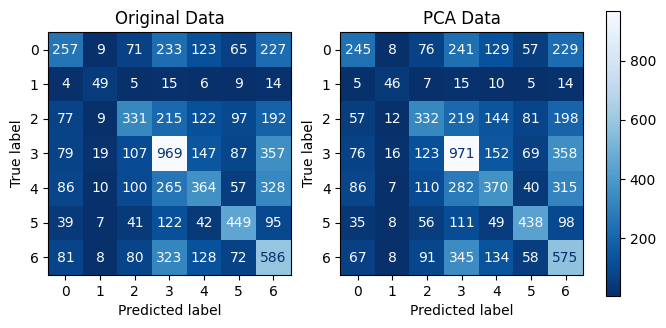

In [ ]:
cm_ori = confusion_matrix(y_test, y_pred_ori)
cm_pca = confusion_matrix(y_test, y_pred_pca)

plt.figure()
# Ma trận nhầm lẫn cho mô hình 1
plt.subplot(1, 2, 1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_ori)
disp_1.plot(ax=plt.gca(), cmap='Blues_r', colorbar=False)
plt.title('Original Data')

# Ma trận nhầm lẫn cho mô hình 2
plt.subplot(1, 2, 2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_pca)
disp_2.plot(ax=plt.gca(), cmap='Blues_r', colorbar=False)
plt.title('PCA Data')

# Hiển thị cả hai ma trận nhầm lẫn
plt.tight_layout()
plt.colorbar(disp_1.im_, ax=plt.gcf().get_axes(), fraction=0.025, pad=0.04)
plt.show()

### Confusion Matrix of MLP Model

#### Original Data

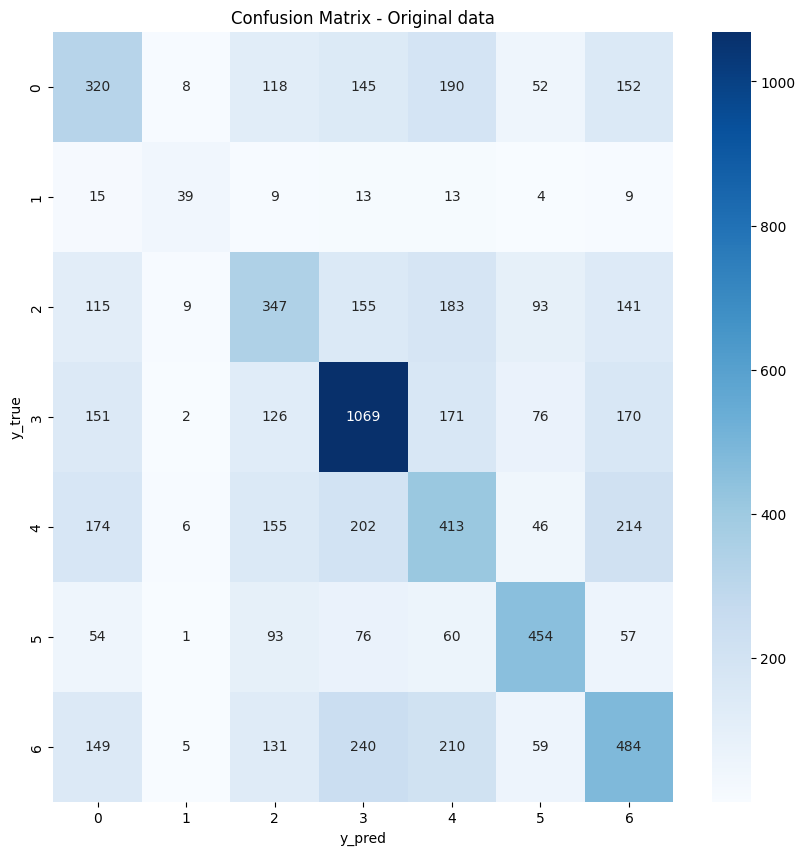

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Confusion Matrix - Original data')
plt.show()

#### PCA Data

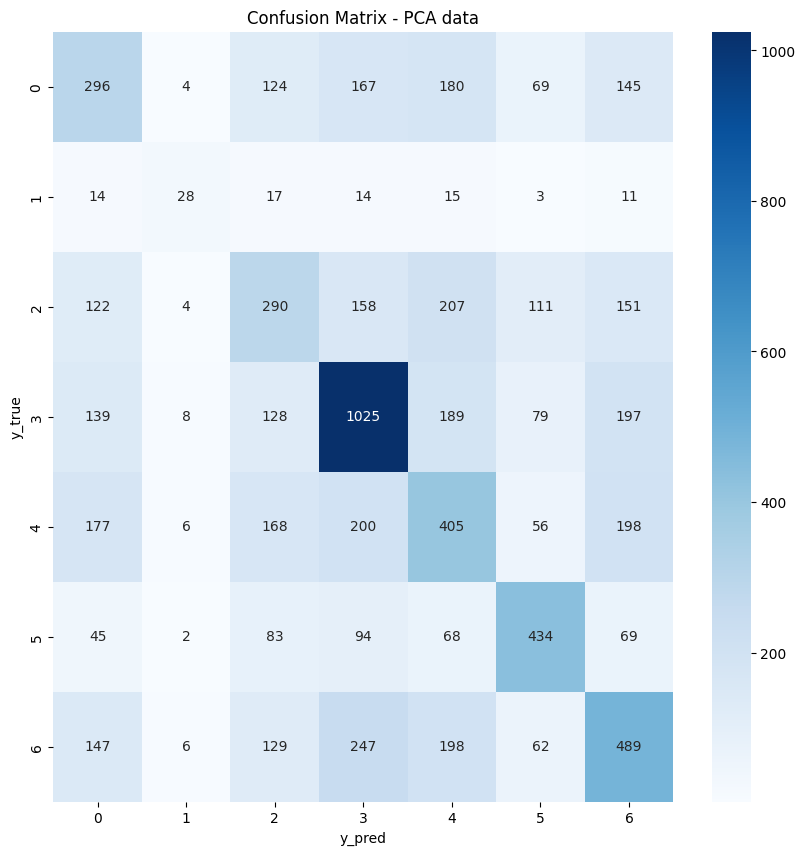

In [ ]:
cm = confusion_matrix(y_test_pca, y_test_pred_pca)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Confusion Matrix - PCA data')
plt.show()

### Confusion Matirx of RDF Model

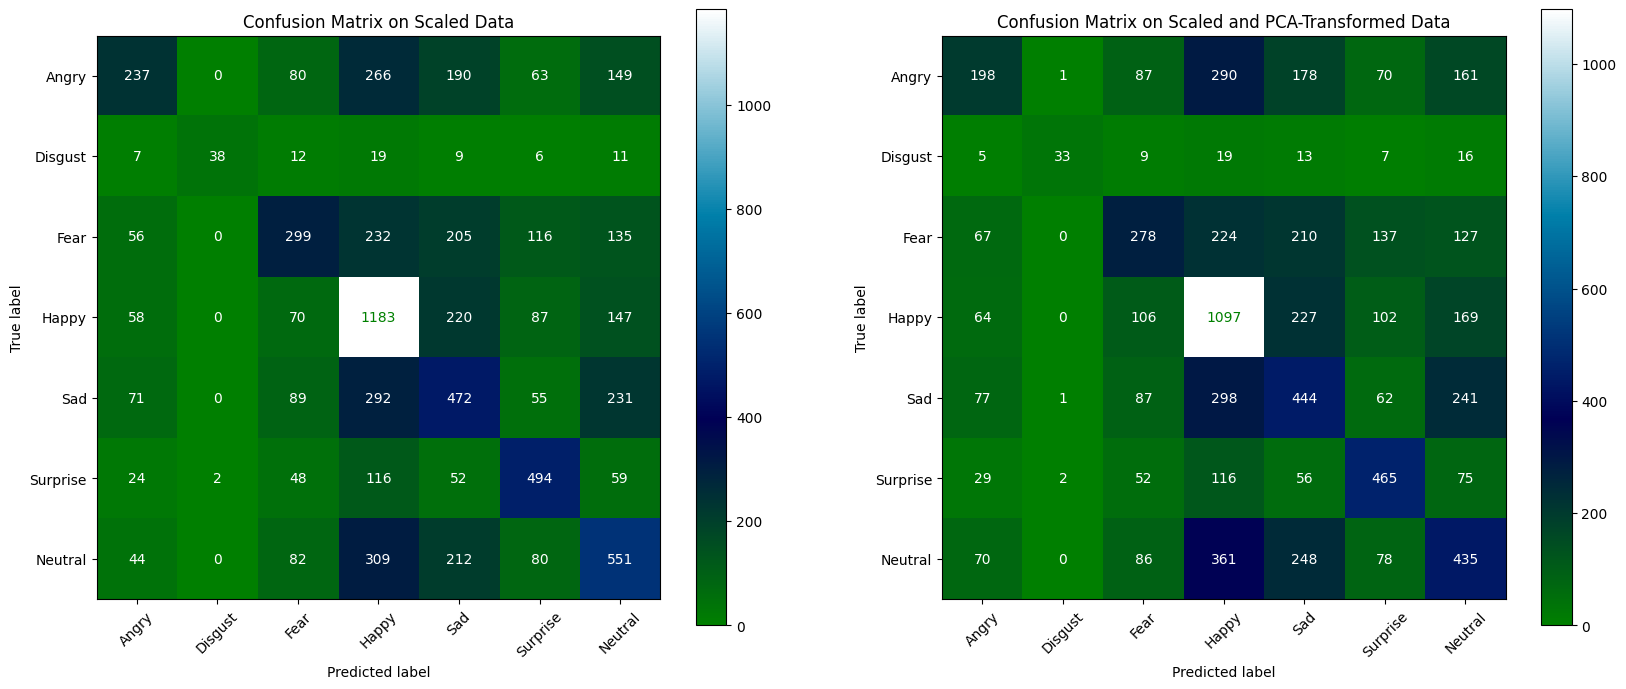

In [ ]:
#Vẽ ma trận nhầm lẫn
conf_matrix_scaled = confusion_matrix(y_test, y_pred_scaled)
conf_matrix_scaled_pca = confusion_matrix(y_test, y_pred_scaled_pca)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
disp_scaled = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_scaled, display_labels=class_names)
disp_scaled_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_scaled_pca, display_labels=class_names)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ma trận nhầm lẫn cho dữ liệu gốc
disp_scaled.plot(ax=axes[0], xticks_rotation='vertical', cmap='ocean')
axes[0].set_title('Confusion Matrix on Scaled Data')
axes[0].set_xticks(np.arange(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_yticks(np.arange(len(class_names)))
axes[0].set_yticklabels(class_names)

# Ma trận nhầm lẫn cho dữ liệu PCA
disp_scaled_pca.plot(ax=axes[1], xticks_rotation='vertical', cmap='ocean')
axes[1].set_title('Confusion Matrix on Scaled and PCA-Transformed Data')
axes[1].set_xticks(np.arange(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=45)
axes[1].set_yticks(np.arange(len(class_names)))
axes[1].set_yticklabels(class_names)

plt.show()

### Confusion Matrix of SVM Model

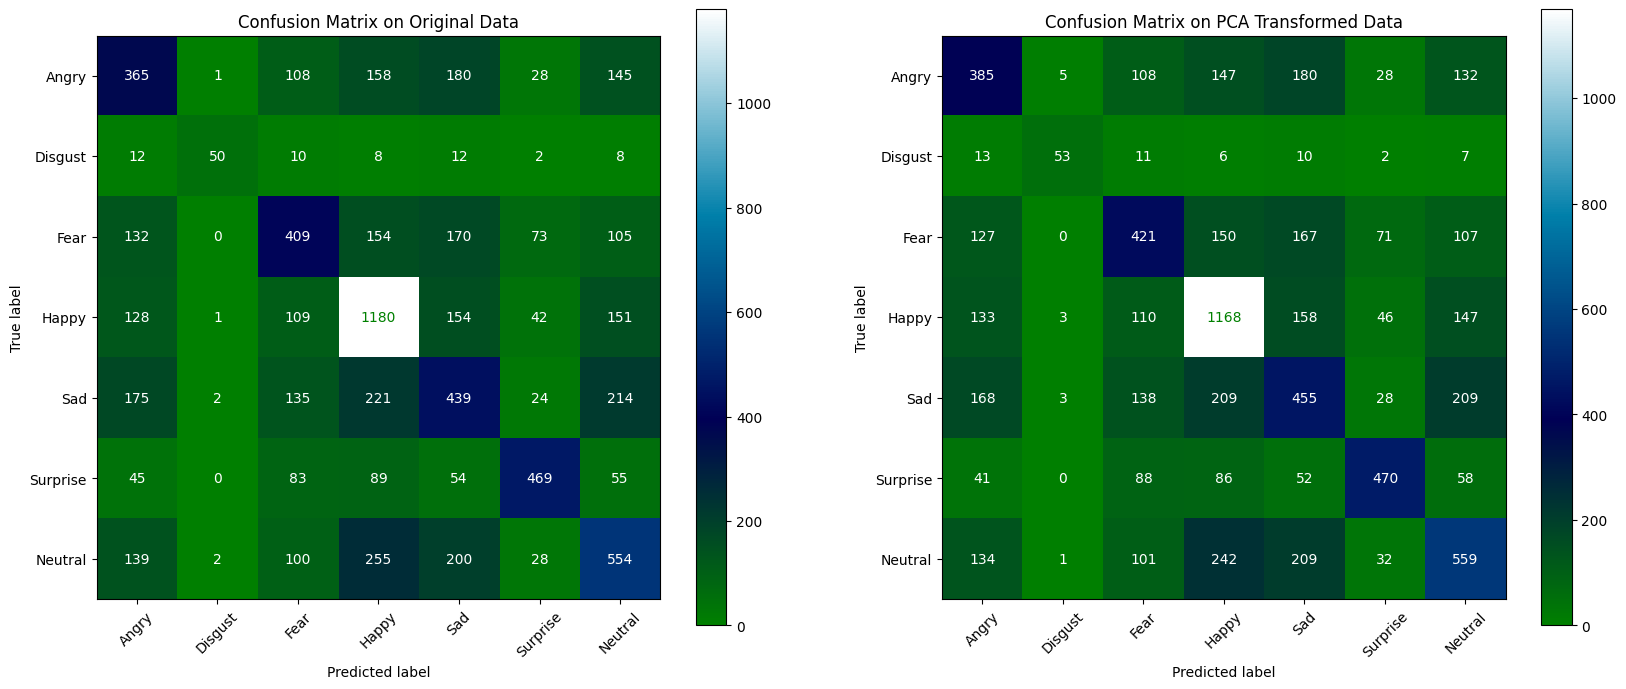

In [ ]:
# Hiển thị ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_pca = confusion_matrix(y_test, y_pred_svm_pca)
disp_original = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_pca)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ma trận nhầm lẫn cho dữ liệu gốc
disp_original.plot(ax=axes[0], xticks_rotation='vertical', cmap='ocean')
axes[0].set_title('Confusion Matrix on Original Data')
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_yticks(np.arange(7))
axes[0].set_yticklabels(class_names)

# Ma trận nhầm lẫn cho dữ liệu PCA
disp_pca.plot(ax=axes[1], xticks_rotation='vertical', cmap='ocean')
axes[1].set_title('Confusion Matrix on PCA Transformed Data')
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(class_names, rotation=45)
axes[1].set_yticks(np.arange(7))
axes[1].set_yticklabels(class_names)

plt.show()


# Question 4

#### Mô Hình SVM
- **Accuracy**: 49%
- **Precision Macro avg**: 0.53
- **Recall Macro avg**: 0.48
- **F1 - Score Macro avg**: 0.50

- **Emotion Category**:
  - **Chính xác nhất**: Lớp 5 với precision (0.69), recall (0.59) và F1 - Score (0.64) cao.
  - **Nhiều lỗi nhất**: Lớp 0 với precision, recall và F1 - Score đều thấp (khoảng 0.38).

#### Mô Hình Random Forest
- **Accuracy**: 41%
- **Precision Macro avg**: 0.47
- **Recall Macro avg**: 0.39
- **F1 - Score Macro avg**: 0.40

- **Emotion Category**:
  - **Chính xác nhất**: Lớp 1 với precision rất cao (0.89) nhưng recall chỉ 0.32.
  - **Nhiều lỗi nhất**: Lớp 0 với recall thấp nhất (0.20) và F1 - Score (0.26).

#### Mô Hình KNN
- **Accuracy**: 41%
- **Precision Macro avg**: 0.43
- **Recall Macro avg**: 0.41
- **F1 - Score Macro avg**: 0.41

- **Emotion Category**:
  - **Chính xác nhất**: Lớp 3 với precision (0.45) và recall (0.51) tốt nhất.
  - **Nhiều lỗi nhất**: Lớp 0 với recall thấp nhất (0.25) và F1 - Score (0.31).

#### Mô Hình MLP
- **Accuracy**: 39%
- **Precision Macro avg**: 0.37
- **Recall Macro avg**: 0.38
- **F1 - Score Macro avg**: 0.38

- **Emotion Category**:
  - **Chính xác nhất**: Lớp 3 với precision (0.52) và F1 - Score (0.52).
  - **Nhiều lỗi nhất**: Lớp 0 với recall thấp (0.28) và F1 - Score (0.29).

### So Sánh Tổng Quan

1. **Accuracy**:
   - **SVM** có precision cao nhất là 49%.
   - **Random Forest** và **KNN** đều đạt 41%.
   - **MLP** có precision thấp nhất là 39%.

2. **Precision Macro avg**:
   - **SVM** cao nhất với 0.53.
   - **MLP** thấp nhất với 0.37.

3. **Recall Macro avg**:
   - **SVM** cao nhất với 0.48.
   - **Random Forest** thấp nhất với 0.39.

4. **F1 - Score Macro avg**:
   - **SVM** tốt nhất với 0.50.
   - **MLP** thấp nhất với 0.38.

### Đánh Giá Hiệu Suất Mô Hình

Dựa trên các số liệu về precision, precision, recall và F1 - Score, mô hình **SVM** là mô hình hoạt động tốt nhất. Điều này là do:

- **Accuracy cao nhất**: Với 49%, SVM có Accuracy cao nhất, cho thấy nó dự đoán chính xác hơn so với các mô hình khác.
- **Precision, recall và F1 - Score cao nhất**: Các chỉ số này cho thấy mô hình có sự cân bằng tốt trong việc nhận diện các lớp khác nhau.

**Lớp cảm xúc chính xác nhất của mô hình SVM** là lớp 5, với F1 - Score là 0.64, cho thấy nó dự đoán tốt các mẫu trong lớp này. **Lớp cảm xúc mà mô hình SVM mắc nhiều lỗi nhất** là lớp 0, với precision, recall và F1 - Score đều thấp (khoảng 0.38), cho thấy mô hình gặp khó khăn trong việc phân loại các mẫu thuộc lớp này.

### Kết Luận
Mô hình **SVM** nổi bật là mô hình tốt nhất trong số các mô hình được xem xét. Nó cung cấp hiệu suất cao nhất trong các chỉ số quan trọng như precision, precision, recall và F1 - Score. Do đó, nếu phải lựa chọn một mô hình để triển khai, SVM là lựa chọn ưu tiên. Trong khi đó, các lớp cảm xúc như lớp 0 là nơi mà mô hình cần được cải thiện để giảm thiểu lỗi phân loại.